# Problem Statment
Predicting the alphabets of Americal Sign Language (ASL) by performing exploratory data analysis, create a training-validation split, and prepare the data for modeling.

## Dataset
The data set is a collection of images of alphabets from the American Sign Language, separated in 29 folders which represent the various classes. The training data set contains 87,000 images which are 200x200 pixels. There are 29 classes, of which 26 are for the letters A-Z and 3 classes for SPACE, DELETE and NOTHING. These 3 classes are very helpful in real-time applications, and classification. The test data set contains a mere 29 images, to encourage the use of real-world test images. https://www.kaggle.com/datasets/grassknoted/asl-alphabet 

## Download the Dataset
We'll use the opendatasets library to download the data from Kaggle directly within Jupyter. Let's install and import opendatasets.

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

The dataset can now be downloaded using od.download. When you execute od.download, we will be asked to provide our Kaggle username and API key.

In [ ]:
ds_url = 'https://www.kaggle.com/datasets/grassknoted/asl-alphabet'
od.download(ds_url)

Skipping, found downloaded files in "./asl-alphabet" (use force=True to force download)


In [ ]:
train_data_dir = './asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_data_dir = './asl-alphabet/asl_alphabet_testasl_alphabet_test'

In [ ]:
import os
os.listdir(train_data_dir)

['T',
 'B',
 'del',
 'M',
 'I',
 'L',
 'K',
 'N',
 'U',
 'nothing',
 'C',
 'D',
 'X',
 'F',
 'Y',
 'Z',
 'Q',
 'G',
 'R',
 'S',
 'A',
 'V',
 'W',
 'O',
 'H',
 'space',
 'J',
 'P',
 'E']

In [ ]:
len(train_data_dir)

52

In [ ]:
from torchvision.datasets import ImageFolder
train_ds = ImageFolder(train_data_dir)

In [ ]:
len(train_ds)

87000

In [ ]:
for cls in os.listdir(train_data_dir):
  print(cls, ':', len(os.listdir(train_data_dir + '/' + cls)))

T : 3000
B : 3000
del : 3000
M : 3000
I : 3000
L : 3000
K : 3000
N : 3000
U : 3000
nothing : 3000
C : 3000
D : 3000
X : 3000
F : 3000
Y : 3000
Z : 3000
Q : 3000
G : 3000
R : 3000
S : 3000
A : 3000
V : 3000
W : 3000
O : 3000
H : 3000
space : 3000
J : 3000
P : 3000
E : 3000


In [ ]:
train_ds[0]

(<PIL.Image.Image image mode=RGB size=200x200 at 0x7F99687A84C0>, 0)

In [ ]:
train_ds.classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

We can view images using matplotlib.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

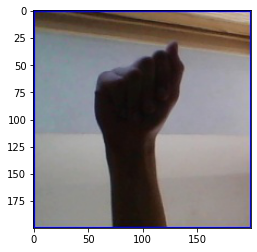

In [ ]:
img, label = train_ds[0]
plt.imshow(img)

### Data Augmentation
We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [ ]:
import torchvision.transforms as tt
train_ds = ImageFolder(train_data_dir, tt.Compose([tt.Resize(64),
                                       tt.RandomCrop(64),
                                       tt.ToTensor()]))

All these transformations in training set is called as Data Augmentation so that model does not overfit the data, weights are more generalized. On the validation dataset we should not be applying the transformation because it will report the performance of the model on that data.

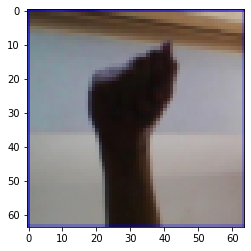

In [ ]:
img, label = train_ds[0]
plt.imshow(img.permute((1,2,0)))

### Spliting the data into training and validation set

In [ ]:
val_pct = 0.2                     # Validation Percentage
val_size = int(val_pct * len(train_ds)) # Validation Size
train_size = len(train_ds) - val_size
train_size, val_size

(69600, 17400)

In [ ]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(val_ds)

(69600, 17400)

### Creating Data Loaders
Next, we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 500 to utlize a larger portion of the GPU RAM. You can try reducing the batch size & restarting the kernel if you face an "out of memory" error.

In [ ]:
batch_size = 256

from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

val_dl = DataLoader(val_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

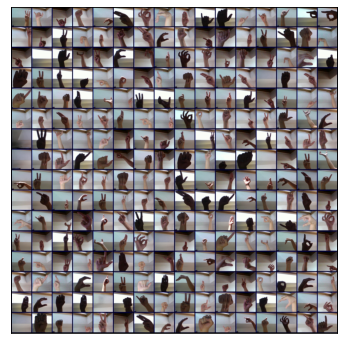

In [ ]:
show_batch(train_dl)

## GPU Utilities
To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [ ]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (torch.device('cpu')) or a GPU (torch.device('cuda'))

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
img, label = train_ds[0]
img.device

device(type='cpu')

In [ ]:
# Bydefault its on CPU so we have to change it
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [ ]:
# Wrapping the training dataloader with the device
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Model & Training Utilities

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):    
      # Calculate Loss for a batch of Training data
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):       
      # Calculate Loss & Accuracy for a batch of Validation data
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  # Evaluates the model's Performance on the Validation dataset
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model
We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input : 128 x 3 x 64 x 64
        
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

Here we first create a list of layers with in & out channels, kernel_size=3 and padding=1, then we have batch normailzation applied to output channels, then we al=pply relu, and then we check if there is a pooling then we append a maxpool2d layer, and then we can sequentially align all the layers by using nn.sequential() function.

In [ ]:
model = to_device(ResNet9(3,len(train_ds)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [ ]:
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  break

images.shape torch.Size([256, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([256, 69600])


In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 11.14206314086914, 'val_acc': 0.0}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [ ]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.6291, val_loss: 0.0239, val_acc: 0.9934
Epoch [1], train_loss: 0.0174, val_loss: 0.0032, val_acc: 0.9995
Epoch [2], train_loss: 0.0117, val_loss: 0.0027, val_acc: 0.9994
Epoch [3], train_loss: 0.0018, val_loss: 0.0009, val_acc: 0.9997
Epoch [4], train_loss: 0.0120, val_loss: 0.0662, val_acc: 0.9756


Our model trained to over 97% accuracy. Try playing around with the data augmentations, network architecture & hyperparameters to achive better results.
Let's plot the valdation set accuracies to study how the model improves over time.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

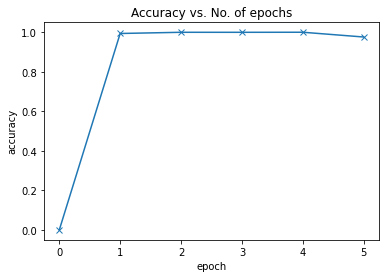

In [ ]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

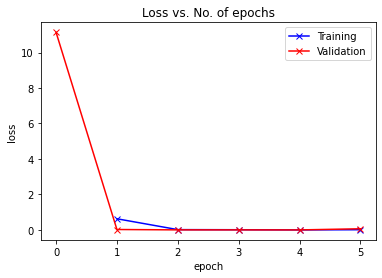

In [ ]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Try removing batch normalization, data augmentation and residual layers one by one to study their effect on overfitting.

In [1]:
!pip install jovian --upgrade --quiet
import jovian
jovian.commit

<function jovian.utils.commit.commit(message=None, files=[], outputs=[], environment=None, privacy='auto', filename=None, project=None, new_project=None, git_commit=False, git_message='auto', require_write_access=False, **kwargs)>

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images.


In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def predictions(num):
  img, label = val_ds[num]
  plt.imshow(img.permute(1,2,0))
  pred = predict_image(img, model, train_ds.classes)
  print('Target :', train_ds.classes[label])
  print('Prediction :', pred)

Target : Z
Prediction : Z


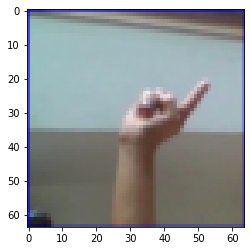

In [ ]:
predictions(0)

Target : V
Prediction : V


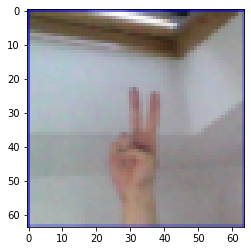

In [ ]:
predictions(10)

Target : del
Prediction : del


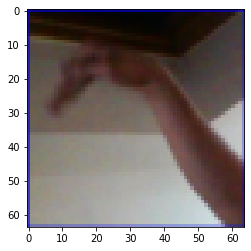

In [ ]:
predictions(121)

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

In [ ]:
torch.save(model.state_dict(), 'asl-resnet9.pth')

In [ ]:
jovian.commit

<function jovian.utils.commit.commit(message=None, files=[], outputs=[], environment=None, privacy='auto', filename=None, project=None, new_project=None, git_commit=False, git_message='auto', require_write_access=False, **kwargs)>

## Transfer Learning

transfer Learning is a technique that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.

How a CNN learns ([source](https://developer.nvidia.com/discover/convolutional-neural-network)):

![cnn-learning](https://developer.nvidia.com/sites/default/files/pictures/2018/convolutional_neural_network.png)

Layer visualization ([source](https://medium.com/analytics-vidhya/deep-learning-visualization-and-interpretation-of-neural-networks-2f3f82f501c5)):

![cnn-learning](https://miro.medium.com/max/1610/1*WysCJ6Ynecvviwctt6WDlQ.png)

In [ ]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(ResNet34(len(train_ds.classes), pretrained=True), device)

In [ ]:
import torchvision.transforms as T

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_ds = ImageFolder(train_data_dir, tt.Compose([tt.Resize(img_size),
                                      tt.RandomCrop(img_size),
                                      tt.ToTensor(),
                                      tt.Normalize(*imagenet_stats)]))

In [ ]:
batch_size = 64

train_ds, val_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(val_ds)

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

val_dl = DataLoader(val_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 3.5701475143432617, 'val_acc': 0.03734735772013664}]

In [ ]:
history += fit_one_cycle(5, 0.001, model, train_dl, val_dl, weight_decay=0.01, grad_clip=0.1, opt_func=torch.optim.Adam)

  0%|          | 0/1088 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.2519, val_loss: 1.6017, val_acc: 0.6004


  0%|          | 0/1088 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.2141, val_loss: 0.5070, val_acc: 0.8979


  0%|          | 0/1088 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.1477, val_loss: 0.1226, val_acc: 0.9849


  0%|          | 0/1088 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0824, val_loss: 0.0452, val_acc: 0.9968


  0%|          | 0/1088 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0497, val_loss: 0.0182, val_acc: 0.9999


As we can see by transfer learning we have improved our model accuracy to 99.99%.

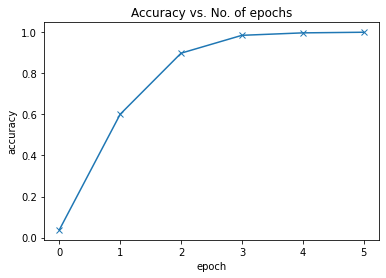

In [ ]:
plot_accuracies(history)

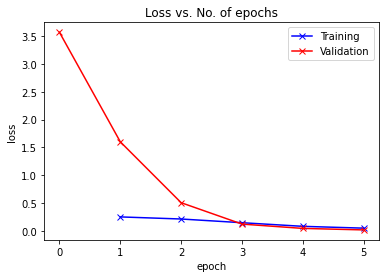

In [ ]:
plot_losses(history)

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', train_ds.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

def predictions_2(num):
  img, label= val_ds[num]
  show_image(img, label)
  pred = predict_image(img, model, train_ds.classes)
  print('Prediction :', pred)

Label: D (3)
Prediction : D


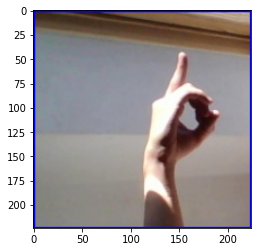

In [ ]:
predictions_2(0)

Label: J (9)
Prediction : J


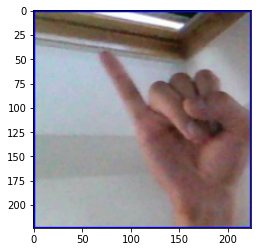

In [ ]:
predictions_2(33)

In [2]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "sayedebad-777/asl-alphabet-recognition" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/sayedebad-777/asl-alphabet-recognition


'https://jovian.com/sayedebad-777/asl-alphabet-recognition'